In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from typing import List, Optional
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
from scipy.stats import gmean, rankdata

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion

In [2]:
def type_selector(df):

    continuous_columns = df.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(df[feature].unique())< 20
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    return categorical_columns, continuous_columns

In [3]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgbm.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=100,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    #print(f"Score mean: {folds_scores.mean()}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
       # print(f"Score mean: {folds_scores.mean()}")
        estimators.append(model)

    return estimators, encoders, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = catb.Pool(x_train, y_train)
        dvalid = catb.Pool(x_valid, y_valid)

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=50, early_stopping_rounds=100
            #categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    #print(f"Score mean: {folds_scores.mean()}")
    print("="*65)
    return estimators, oof_preds

    return estimators, encoders, oof_preds

In [4]:
train = pd.read_csv('./prepared_data/train.csv')
test = pd.read_csv('./prepared_data/test.csv')

In [5]:
dummies_features = pd.get_dummies(train['NAME_CONTRACT_TYPE'])
train = pd.concat([train, dummies_features], axis=1)
dummies_features = dummies_features.columns.tolist()
train = train.drop("NAME_CONTRACT_TYPE", axis=1)

In [6]:
dummies_features = pd.get_dummies(test['NAME_CONTRACT_TYPE'])
test = pd.concat([test, dummies_features], axis=1)
dummies_features = dummies_features.columns.tolist()
test = test.drop("NAME_CONTRACT_TYPE", axis=1)

In [7]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [8]:

X_train, X_test, y_train, y_test = train_test_split(train.drop("TARGET",1), 
                                                    train['TARGET'], random_state=0)

In [9]:
params_lgbm = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.04,          
                  "class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 48,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 6,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

cv = KFold(n_splits=5, random_state=435, shuffle=True)
target, data = train["TARGET"], train.drop("TARGET", 1)

In [10]:
estimators_lgbm_basic, oof_preds_lgbm_basic = lightgbm_cross_validation(
    params_lgbm, data, target, cv
)

Mon Apr 26 00:52:04 2021, Cross-Validation, 110093 rows, 193 cols
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.724623
[100]	valid_0's auc: 0.730988
[150]	valid_0's auc: 0.733117
[200]	valid_0's auc: 0.733845
[250]	valid_0's auc: 0.73265
Early stopping, best iteration is:
[200]	valid_0's auc: 0.733845
Fold 1, Valid score = 0.73384


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.730282
[100]	valid_0's auc: 0.736147
[150]	valid_0's auc: 0.737991
[200]	valid_0's auc: 0.73734
Early stopping, best iteration is:
[152]	valid_0's auc: 0.738071
Fold 2, Valid score = 0.73807


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.706099
[100]	valid_0's auc: 0.710611
[150]	valid_0's auc: 0.712365
[200]	valid_0's auc: 0.713316
[250]	valid_0's auc: 0.713003
Early stopping, best iteration is:
[221]	valid_0's auc: 0.71367
Fold 3, Valid score = 0.71367
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.709853
[100]	valid_0's auc: 0.713982
[150]	valid_0's auc: 0.715099
Early stopping, best iteration is:
[138]	valid_0's auc: 0.715607
Fold 4, Valid score = 0.71561


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.713873
[100]	valid_0's auc: 0.719476
[150]	valid_0's auc: 0.720051
Early stopping, best iteration is:
[136]	valid_0's auc: 0.720606
Fold 5, Valid score = 0.72061
Score by each fold: [0.73384, 0.73807, 0.71367, 0.71561, 0.72061]


In [13]:
xgb_params = {
    "booster": "gbtree", 
    "objective": "binary:logistic", 
    "eval_metric": "auc", 
    "learning_rate": 0.03,  
    "reg_lambda": 100, 
    "max_depth": 6, 
    "gamma": 10, 
    "nthread": -1, 
    "seed": 27} 


xgb_cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [14]:
xgb_estimators_basic, _, xgb_oof_basic = xgboost_cross_validation(
    xgb_params, data, target, xgb_cv)

Mon Apr 26 00:57:33 2021, Cross-Validation, 110093 rows, 193 cols
[0]	train-auc:0.59747	valid-auc:0.61311
[10]	train-auc:0.67669	valid-auc:0.69183
[20]	train-auc:0.68103	valid-auc:0.69531
[30]	train-auc:0.68122	valid-auc:0.69548
[40]	train-auc:0.68490	valid-auc:0.69958
[50]	train-auc:0.68836	valid-auc:0.70154
[60]	train-auc:0.69255	valid-auc:0.70277
[70]	train-auc:0.69493	valid-auc:0.70592
[80]	train-auc:0.70322	valid-auc:0.71343
[90]	train-auc:0.70626	valid-auc:0.71597
[100]	train-auc:0.71075	valid-auc:0.71941
[110]	train-auc:0.71501	valid-auc:0.72214
[120]	train-auc:0.71825	valid-auc:0.72489
[130]	train-auc:0.72082	valid-auc:0.72704
[140]	train-auc:0.72364	valid-auc:0.72952
[150]	train-auc:0.72643	valid-auc:0.73225
[160]	train-auc:0.72835	valid-auc:0.73417
[170]	train-auc:0.72983	valid-auc:0.73520
[180]	train-auc:0.73123	valid-auc:0.73580
[190]	train-auc:0.73252	valid-auc:0.73619
[200]	train-auc:0.73364	valid-auc:0.73646
[210]	train-auc:0.73468	valid-auc:0.73679
[220]	train-auc:0.735

In [15]:
params_catb = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "task_type": "CPU",
    "learning_rate":0.03,
    "max_bin": 30,
    "verbose": 200,
    "max_depth": 6,
    "l2_leaf_reg": 40,
    "early_stopping_rounds": 50,
    "thread_count": -1,
    "random_seed": 42,
    "eval_metric":"AUC",
}


In [16]:
cv = KFold(n_splits=5, random_state=435, shuffle=True)
target, data = train["TARGET"], train.drop("TARGET", 1)

catb_estimators_basic, catb_oof_basic = catboost_cross_validation(
    params_catb, data, target, cv)

Mon Apr 26 01:04:47 2021, Cross-Validation, 110093 rows, 193 cols
0:	test: 0.5780292	best: 0.5780292 (0)	total: 209ms	remaining: 34m 50s
50:	test: 0.7161225	best: 0.7161225 (50)	total: 1.49s	remaining: 4m 51s
100:	test: 0.7237723	best: 0.7238057 (99)	total: 2.74s	remaining: 4m 28s
150:	test: 0.7279528	best: 0.7279528 (150)	total: 4s	remaining: 4m 20s
200:	test: 0.7298424	best: 0.7298932 (198)	total: 5.21s	remaining: 4m 13s
250:	test: 0.7306236	best: 0.7306455 (249)	total: 6.39s	remaining: 4m 8s
300:	test: 0.7307510	best: 0.7308855 (282)	total: 7.57s	remaining: 4m 3s
350:	test: 0.7312191	best: 0.7312191 (350)	total: 8.76s	remaining: 4m
400:	test: 0.7313545	best: 0.7314160 (379)	total: 9.95s	remaining: 3m 58s
450:	test: 0.7311267	best: 0.7316061 (408)	total: 11.1s	remaining: 3m 55s
500:	test: 0.7315715	best: 0.7316415 (486)	total: 12.3s	remaining: 3m 53s
550:	test: 0.7320326	best: 0.7321345 (529)	total: 13.5s	remaining: 3m 51s
600:	test: 0.7322030	best: 0.7323436 (569)	total: 14.7s	remai

In [150]:
params_lgbm = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.04,          
                  "class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 48,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 6,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [151]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.782936	valid_1's auc: 0.726687
Early stopping, best iteration is:
[197]	training's auc: 0.782285	valid_1's auc: 0.726696


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.04, max_depth=6,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [152]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


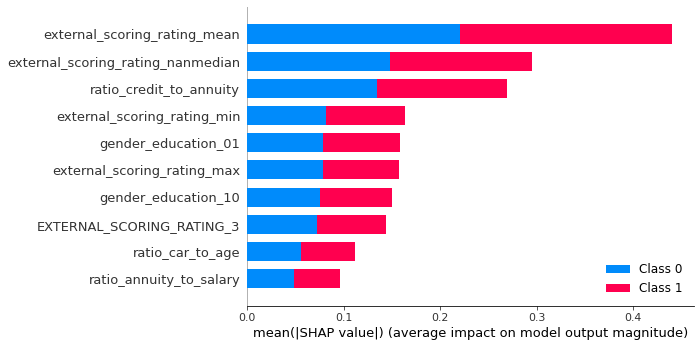

In [153]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

In [154]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']

0     18136.667012
2     12171.867163
1     11106.167653
6      6636.070523
5      6545.131573
3      6509.944721
7      6249.445141
4      5893.476249
8      4570.819947
10     3973.075293
13     3593.408861
14     3277.850664
11     3197.161461
9      3192.251375
16     3037.746241
15     3003.327574
12     2788.244478
19     2764.468472
17     2650.447469
21     2590.161498
23     2517.235353
25     2501.148903
18     2454.707984
22     2179.319211
35     2095.089679
20     2080.544067
29     1794.050725
26     1725.504528
36     1718.188214
33     1668.526916
38     1647.803605
32     1636.393448
37     1564.610355
24     1524.029814
30     1381.620841
27     1358.904643
28     1284.624375
31     1145.455027
34     1120.233097
Name: feature_importance_vals, dtype: float64

In [22]:
feature_importance_mean = feature_importance['feature_importance_vals'].mean()

In [155]:
feature_importance = feature_importance.loc[feature_importance['feature_importance_vals'] > 0]

In [156]:
feature_importance = feature_importance['col_name'].tolist()

In [157]:
X_train, X_test, y_train, y_test = train_test_split(train[feature_importance], 
                                                    train['TARGET'], random_state=0)

In [158]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.783588	valid_1's auc: 0.727367
Early stopping, best iteration is:
[178]	training's auc: 0.779849	valid_1's auc: 0.727679


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.04, max_depth=6,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [159]:
cv = KFold(n_splits=5, random_state=435, shuffle=True)
target, data = train["TARGET"], train[feature_importance]

In [160]:
params_lgbm = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.03,          
                  "class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 48,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 6,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [161]:
estimators_lgbm_feature_importance, oof_preds_lgbm_feature_importance = lightgbm_cross_validation(
    params_lgbm, data, target, cv
)

Mon Apr 26 01:15:55 2021, Cross-Validation, 110093 rows, 39 cols
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.725029
[100]	valid_0's auc: 0.730703
[150]	valid_0's auc: 0.734513
[200]	valid_0's auc: 0.736423
[250]	valid_0's auc: 0.737555
[300]	valid_0's auc: 0.737991
[350]	valid_0's auc: 0.738426
[400]	valid_0's auc: 0.73862
[450]	valid_0's auc: 0.738644
Early stopping, best iteration is:
[423]	valid_0's auc: 0.738883
Fold 1, Valid score = 0.73888
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's auc: 0.728196
[100]	valid_0's auc: 0.734107
[150]	valid_0's auc: 0.738507
[200]	valid_0's auc: 0.740017
[250]	valid_0's auc: 0.740365
[300]	valid_0's auc: 0.740202
Early stopping, best iteration is:
[277]	valid_0's auc: 0.740624
Fold 2, Valid score = 0.74062
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.704096
[100]	valid_0's auc: 0.709714
[150]	valid_0's auc: 0.712529
[200]	valid_0's auc: 0.714428
[250]	valid_0's auc: 0.715621
[300]	valid_0's auc: 0.715997
Early stopping, best iteration is:
[276]	valid_0's auc: 0.716128
Fold 3, Valid score = 0.71613
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.708816
[100]	valid_0's auc: 0.713777
[150]	valid_0's auc: 0.718198
[200]	valid_0's auc: 0.720938
[250]	valid_0's auc: 0.722124
[300]	valid_0's auc: 0.722919
[350]	valid_0's auc: 0.723086
Early stopping, best iteration is:
[316]	valid_0's auc: 0.723314
Fold 4, Valid score = 0.72331


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.716021
[100]	valid_0's auc: 0.720568
[150]	valid_0's auc: 0.724239
[200]	valid_0's auc: 0.724728
[250]	valid_0's auc: 0.725225
[300]	valid_0's auc: 0.725944
Early stopping, best iteration is:
[298]	valid_0's auc: 0.726011
Fold 5, Valid score = 0.72601
Score by each fold: [0.73888, 0.74062, 0.71613, 0.72331, 0.72601]


In [162]:
xgb_params = {
    "booster": "gbtree", 
    "objective": "binary:logistic", 
    "eval_metric": "auc", 
    "learning_rate": 0.03,  
    "reg_lambda": 100, 
    "max_depth": 6, 
    "gamma": 10, 
    "nthread": -1, 
    "seed": 27} 


xgb_cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [163]:
xgb_estimators_feature_importance, _, xgb_oof_feature_importance = xgboost_cross_validation(
    xgb_params, data, target, xgb_cv)

Mon Apr 26 01:16:04 2021, Cross-Validation, 110093 rows, 39 cols
[0]	train-auc:0.59747	valid-auc:0.61311
[10]	train-auc:0.67663	valid-auc:0.69192
[20]	train-auc:0.68098	valid-auc:0.69526
[30]	train-auc:0.68118	valid-auc:0.69544
[40]	train-auc:0.68480	valid-auc:0.69962
[50]	train-auc:0.68806	valid-auc:0.70147
[60]	train-auc:0.69244	valid-auc:0.70269
[70]	train-auc:0.69453	valid-auc:0.70586
[80]	train-auc:0.70203	valid-auc:0.71343
[90]	train-auc:0.70529	valid-auc:0.71614
[100]	train-auc:0.70870	valid-auc:0.71855
[110]	train-auc:0.71232	valid-auc:0.72132
[120]	train-auc:0.71564	valid-auc:0.72454
[130]	train-auc:0.71853	valid-auc:0.72689
[140]	train-auc:0.72138	valid-auc:0.72940
[150]	train-auc:0.72390	valid-auc:0.73217
[160]	train-auc:0.72565	valid-auc:0.73388
[170]	train-auc:0.72711	valid-auc:0.73504
[180]	train-auc:0.72861	valid-auc:0.73608
[190]	train-auc:0.72985	valid-auc:0.73711
[200]	train-auc:0.73104	valid-auc:0.73760
[210]	train-auc:0.73200	valid-auc:0.73800
[220]	train-auc:0.7328

In [164]:
params_catb = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "task_type": "CPU",
    "learning_rate":0.03,
    "max_bin": 30,
    "verbose": 200,
    "max_depth": 6,
    "l2_leaf_reg": 40,
    "early_stopping_rounds": 50,
    "thread_count": -1,
    "random_seed": 42,
    "eval_metric":"AUC",
}


In [165]:
cv = KFold(n_splits=5, random_state=435, shuffle=True)
target, data = train["TARGET"], train.drop("TARGET", 1)

catb_estimators_feature_importance, catb_oof_feature_importance = catboost_cross_validation(
    params_catb, data, target, cv)

Mon Apr 26 01:17:31 2021, Cross-Validation, 110093 rows, 193 cols
0:	test: 0.5780292	best: 0.5780292 (0)	total: 30.8ms	remaining: 5m 7s
50:	test: 0.7161225	best: 0.7161225 (50)	total: 1.3s	remaining: 4m 13s
100:	test: 0.7237723	best: 0.7238057 (99)	total: 2.53s	remaining: 4m 7s
150:	test: 0.7279528	best: 0.7279528 (150)	total: 3.76s	remaining: 4m 5s
200:	test: 0.7298424	best: 0.7298932 (198)	total: 4.99s	remaining: 4m 3s
250:	test: 0.7306236	best: 0.7306455 (249)	total: 6.21s	remaining: 4m 1s
300:	test: 0.7307510	best: 0.7308855 (282)	total: 7.42s	remaining: 3m 59s
350:	test: 0.7312191	best: 0.7312191 (350)	total: 8.62s	remaining: 3m 56s
400:	test: 0.7313545	best: 0.7314160 (379)	total: 9.81s	remaining: 3m 54s
450:	test: 0.7311267	best: 0.7316061 (408)	total: 11s	remaining: 3m 52s
500:	test: 0.7315715	best: 0.7316415 (486)	total: 12.2s	remaining: 3m 50s
550:	test: 0.7320326	best: 0.7321345 (529)	total: 13.4s	remaining: 3m 49s
600:	test: 0.7322030	best: 0.7323436 (569)	total: 14.5s	rema

In [166]:
train[feature_importance]

,external_scoring_rating_mean,external_scoring_rating_nanmedian,ratio_credit_to_annuity,external_scoring_rating_min,gender_education_01,external_scoring_rating_max,gender_education_10,EXTERNAL_SCORING_RATING_3,ratio_car_to_age,ratio_annuity_to_salary,...,AMOUNT_ANNUITY,DAYS_INSTALMENT_meanAPPLICATION_NUMBER,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_stdAPPLICATION_NUMBER,bki_kurtosis_count_APPLICATION_NUMBER_CLIENT_PL,OWN_CAR_AGE_count_APPLICATION_NUMBER_CLIENT_PL,ratio_credit_to_annuity_count_APPLICATION_NUMBER_CLIENT_PL,ratio_credit_to_experience,ratio_annuity_to_age,DAYS_ON_LAST_JOB_minAPPLICATION_NUMBER_CLIENT_PL,AMT_REQ_CREDIT_BUREAU_mon_qtr_01
0,0.687988,0.700684,34.031250,0.645996,0,0.716797,1,0.716797,0.000700,0.159546,...,25128.0,123601380.0,103063.050,15565.0,3392.0,66.0,497.38220,1.597656,123432500.0,0
1,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,...,NaN,123599570.0,102534.690,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.475098,0.475098,23.609375,0.267822,1,0.682129,0,0.267822,NaN,0.315918,...,42660.0,123602030.0,105381.320,13.0,NaN,360.0,278.30847,1.978516,123434584.0,0
3,0.170898,0.170898,22.578125,0.170410,0,0.171265,1,0.170410,NaN,0.127686,...,22972.5,123593160.0,103019.625,41366.0,NaN,44.0,NaN,1.028320,NaN,0
4,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,...,NaN,123598330.0,102644.625,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,...,NaN,123601630.0,95806.840,NaN,NaN,NaN,NaN,NaN,NaN,0
110089,0.527344,0.528320,21.359375,0.471680,0,0.581543,0,0.581543,NaN,0.071899,...,12618.0,123599230.0,100223.960,82231.0,NaN,10.0,199.07681,1.199219,123424210.0,0
110090,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,...,NaN,123604770.0,102779.016,NaN,NaN,NaN,NaN,NaN,NaN,0
110091,0.621094,0.651367,20.734375,0.558594,0,0.653809,0,0.558594,0.001466,0.183105,...,49428.0,NaN,101939.590,16490.0,1000.0,80.0,2838.61500,3.292969,123427050.0,0


In [167]:
asd

NameError: name 'asd' is not defined

In [174]:
scores = pd.DataFrame({
    #"oof_preds_lgbm_basic": oof_preds_lgbm_basic,
    #"xgb_oof_basic": xgb_oof_basic,
    "catb_oof_basic": catb_oof_basic,
    "oof_preds_lgbm_freg_enc": oof_preds_lgbm_feature_importance,
    #"xgb_oof_freg_enc": xgb_oof_feature_importance,
    #"catb_oof_freg_enc": catb_oof_feature_importance
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

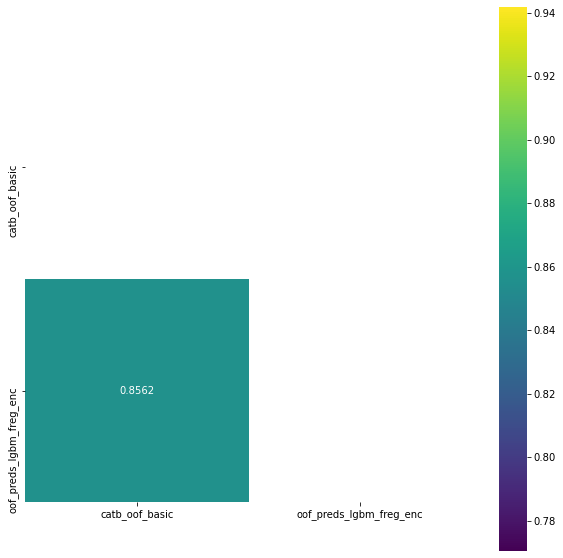

In [175]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [176]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 5)}")

Score = 0.72904


In [177]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 5)}")

Score = 0.72724


In [178]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 5)}")

Score = 0.72822


In [179]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 5)}")

Score = 0.72818


In [180]:
#lgbm_basic_0 = estimators_lgbm_basic[0].predict_proba(test)[:, 1]
#lgbm_basic_1 = estimators_lgbm_basic[1].predict_proba(test)[:, 1]
#lgbm_basic_2 = estimators_lgbm_basic[2].predict_proba(test)[:, 1]
#lgbm_basic_3 = estimators_lgbm_basic[3].predict_proba(test)[:, 1]
#lgbm_basic_4 = estimators_lgbm_basic[4].predict_proba(test)[:, 1]
#lgbm_basic_5 = estimators_lgbm_basic[5].predict_proba(test)[:, 1]
lgbm_freg_enc_0 = estimators_lgbm_feature_importance[0].predict_proba(test[feature_importance])[:, 1]
lgbm_freg_enc_1 = estimators_lgbm_feature_importance[1].predict_proba(test[feature_importance])[:, 1]
lgbm_freg_enc_2 = estimators_lgbm_feature_importance[2].predict_proba(test[feature_importance])[:, 1]
lgbm_freg_enc_3 = estimators_lgbm_feature_importance[3].predict_proba(test[feature_importance])[:, 1]
lgbm_freg_enc_4 = estimators_lgbm_feature_importance[4].predict_proba(test[feature_importance])[:, 1]
#lgbm_freg_enc_5 = estimators_lgbm_feature_importance[5].predict_proba(test[feature_importance])[:, 1]

In [181]:
cols_when_model_builds_test = xgb_estimators_basic[0].feature_names
cols_when_model_builds_freg_enc = xgb_estimators_feature_importance[0].feature_names

In [182]:
xgb_basic_0 = xgb_estimators_basic[0].predict(xgb.DMatrix(test[cols_when_model_builds_test]))
xgb_basic_1 = xgb_estimators_basic[1].predict(xgb.DMatrix(test[cols_when_model_builds_test]))
xgb_basic_2 = xgb_estimators_basic[2].predict(xgb.DMatrix(test[cols_when_model_builds_test]))
xgb_basic_3 = xgb_estimators_basic[3].predict(xgb.DMatrix(test[cols_when_model_builds_test]))
xgb_basic_4 = xgb_estimators_basic[4].predict(xgb.DMatrix(test[cols_when_model_builds_test]))
#xgb_basic_5 = xgb_estimators_basic[5].predict(xgb.DMatrix(test[cols_when_model_builds_test]))
xgb_estimators_feature_importance_0 = xgb_estimators_feature_importance[0].predict(xgb.DMatrix(test[cols_when_model_builds_freg_enc]))
xgb_estimators_feature_importance_1 = xgb_estimators_feature_importance[1].predict(xgb.DMatrix(test[cols_when_model_builds_freg_enc]))
xgb_estimators_feature_importance_2 = xgb_estimators_feature_importance[2].predict(xgb.DMatrix(test[cols_when_model_builds_freg_enc]))
xgb_estimators_feature_importance_3 = xgb_estimators_feature_importance[3].predict(xgb.DMatrix(test[cols_when_model_builds_freg_enc]))
xgb_estimators_feature_importance_4 = xgb_estimators_feature_importance[4].predict(xgb.DMatrix(test[cols_when_model_builds_freg_enc]))
#xgb_estimators_feature_importance_5 = xgb_estimators_feature_importance[5].predict(xgb.DMatrix(test[cols_when_model_builds_freg_enc]))


In [183]:
catb_basic_0 = catb_estimators_basic[0].predict_proba(test)[:, 1]
catb_basic_1 = catb_estimators_basic[1].predict_proba(test)[:, 1]
catb_basic_2 = catb_estimators_basic[2].predict_proba(test)[:, 1]
catb_basic_3 = catb_estimators_basic[3].predict_proba(test)[:, 1]
catb_basic_4 = catb_estimators_basic[4].predict_proba(test)[:, 1]
#catb_basic_5 = catb_estimators_basic[5].predict_proba(test)[:, 1]

#catb_estimators_feature_importance_0 = catb_estimators_feature_importance[0].predict_proba(test[feature_importance])[:, 1]
#catb_estimators_feature_importance_1 = catb_estimators_feature_importance[1].predict_proba(test[feature_importance])[:, 1]
#catb_estimators_feature_importance_2 = catb_estimators_feature_importance[2].predict_proba(test[feature_importance])[:, 1]
#catb_estimators_feature_importance_3 = catb_estimators_feature_importance[3].predict_proba(test[feature_importance])[:, 1]
#catb_estimators_feature_importance_4 = catb_estimators_feature_importance[4].predict_proba(test[feature_importance])[:, 1]
#catb_estimators_feature_importance_5 = catb_estimators_feature_importance[5].predict_proba(test[feature_importance])[:, 1]

In [184]:
scores = pd.DataFrame({
    'lgbm_freg_enc_0':lgbm_freg_enc_0,
    'lgbm_freg_enc_1':lgbm_freg_enc_1,
    'lgbm_freg_enc_2':lgbm_freg_enc_2,
    'lgbm_freg_enc_3':lgbm_freg_enc_3,
    'lgbm_freg_enc_4':lgbm_freg_enc_4,
    #'lgbm_freg_enc_5':lgbm_freg_enc_5,
    #'xgb_basic_0':xgb_basic_0,
    #'xgb_basic_1':xgb_basic_1,
    #'xgb_basic_2':xgb_basic_2,
    #'xgb_basic_3':xgb_basic_3,
    #'xgb_basic_4':xgb_basic_4,
    #'xgb_basic_5':xgb_basic_5,
    #'xgb_estimators_feature_importance_0':xgb_estimators_feature_importance_0,
    #'xgb_estimators_feature_importance_1':xgb_estimators_feature_importance_1,
    #'xgb_estimators_feature_importance_2':xgb_estimators_feature_importance_2,
    #'xgb_estimators_feature_importance_3':xgb_estimators_feature_importance_3,
    #'xgb_estimators_feature_importance_4':xgb_estimators_feature_importance_4,
    #'xgb_estimators_feature_importance_5':xgb_estimators_feature_importance_5,
    'catb_basic_0':catb_basic_0,
    'catb_basic_1':catb_basic_1,
    'catb_basic_2':catb_basic_2,
    'catb_basic_3':catb_basic_3,
    'catb_basic_4':catb_basic_4,
    #'catb_basic_5':catb_basic_5
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

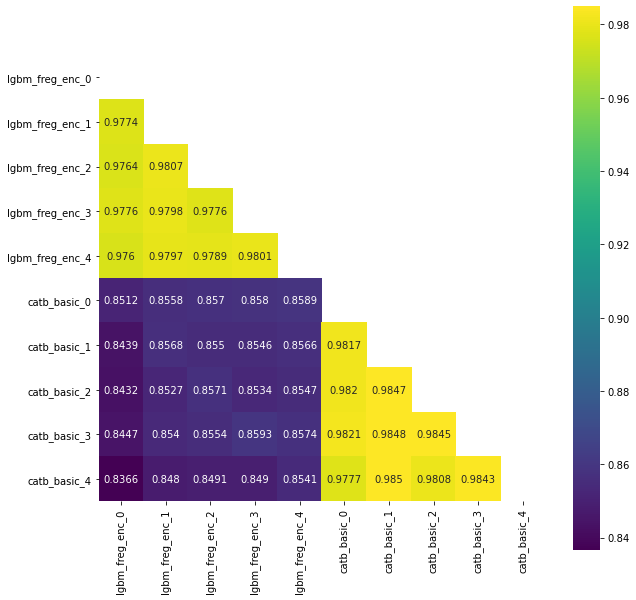

In [185]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [186]:
scores

,lgbm_freg_enc_0,lgbm_freg_enc_1,lgbm_freg_enc_2,lgbm_freg_enc_3,lgbm_freg_enc_4,catb_basic_0,catb_basic_1,catb_basic_2,catb_basic_3,catb_basic_4
0,0.384713,0.377406,0.392050,0.415249,0.358668,0.045806,0.055455,0.054409,0.054555,0.062716
1,0.788451,0.786229,0.786560,0.784503,0.799013,0.213351,0.232290,0.241529,0.215215,0.201972
2,0.669967,0.668056,0.654768,0.678451,0.631081,0.144889,0.176674,0.174452,0.179594,0.163563
3,0.523526,0.525055,0.526586,0.522858,0.518205,0.096903,0.088197,0.093751,0.083971,0.085669
4,0.130707,0.140489,0.118217,0.153310,0.159798,0.028483,0.027849,0.027607,0.024078,0.030164
...,...,...,...,...,...,...,...,...,...,...
165136,0.504562,0.493361,0.499030,0.496312,0.506163,0.075566,0.076356,0.074152,0.077642,0.079176
165137,0.331415,0.327063,0.335005,0.267020,0.371092,0.041948,0.041139,0.045838,0.042957,0.041556
165138,0.492689,0.508311,0.493314,0.483120,0.512495,0.085999,0.084821,0.088537,0.080393,0.083026
165139,0.066933,0.109192,0.139399,0.100579,0.106671,0.015121,0.015719,0.016225,0.017101,0.020153


In [187]:
scores_mean = scores.mean(axis=1)

In [188]:
scores_mean

0         0.220103
1         0.504911
2         0.414149
3         0.306472
4         0.084070
            ...   
165136    0.288232
165137    0.184503
165138    0.291271
165139    0.060709
165140    0.190512
Length: 165141, dtype: float64

In [189]:
preds_final = pd.DataFrame()
preds_final['APPLICATION_NUMBER'] = test.APPLICATION_NUMBER.copy()

In [190]:
preds_final['TARGET'] = scores_mean
preds_final.to_csv('predictions.csv', index=False)

preds_final.describe()

,APPLICATION_NUMBER,TARGET
count,1.651410e+05,165141.000000
mean,1.235771e+08,0.248445
std,8.875606e+04,0.123871
min,1.234233e+08,0.016120
25%,1.235001e+08,0.149289
50%,1.235772e+08,0.250383
75%,1.236541e+08,0.308041
max,1.237309e+08,0.775992


In [ ]:
preds_final.head()